In [3]:
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
from yahoo_fin.stock_info import *

import pandas as pd
import numpy as np
pd.options.display.max_rows    
pd.options.display.max_columns = 50
pd.options.display.max_rows = 25
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import cufflinks as cf
cf.go_offline(connected=True)

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sm, med, lg = 10, 15, 20
plt.rc('font', size = sm)         # controls default text sizes
plt.rc('axes', titlesize = med)   # fontsize of the axes title
plt.rc('axes', labelsize = med)   # fontsize of the x & y labels
plt.rc('xtick', labelsize = sm)   # fontsize of the tick labels
plt.rc('ytick', labelsize = sm)   # fontsize of the tick labels
plt.rc('legend', fontsize = sm)   # legend fontsize
plt.rc('figure', titlesize = lg)  # fontsize of the figure title
plt.rc('axes', linewidth=2)       # linewidth of plot lines
plt.rcParams['figure.dpi'] = 150

from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    tf.config.experimental.set_synchronous_execution(enable=True)
    tf.config.experimental.enable_mlir_bridge()
    tf.config.experimental.enable_tensor_float_32_execution(enabled=True)
    tf.config.threading.get_inter_op_parallelism_threads()
    tf.config.threading.set_inter_op_parallelism_threads(0)
else:
    print('Using CPU')

print('SYSTEM LOAD COMPLETE')

Using GPU
SYSTEM LOAD COMPLETE


In [89]:
# gainers = get_day_gainers()
# gainers[:25]

In [90]:
# losers = (get_day_losers())
# losers[:25]

In [4]:
import pandas as pd
import os
import yfinance as yf
from yfinance import Ticker
import requests


# Class setup
class MovingAverage():
    def __init__(self, closing_prices):
        self.data = pd.DataFrame(closing_prices) 

    def EMA(self, averaging_length=50):
        ret = self.data.ewm(
            span=averaging_length, 
            adjust=False).mean()
        return ret.rename(columns={'Close': 'EMA'})

    def MACD(self, a=12, b=26, c=9):
        MACD_line = self.EMA(a) - self.EMA(b)
        signal_line = MACD_line.ewm(span=c, adjust=False).mean()
        histogram = MACD_line - signal_line
        return MACD_line, signal_line, histogram



ticker_stock = 'AAPL'
stock_ticker = Ticker(ticker_stock)
df = stock_ticker.history(period='1y',parsed_dates=True)

df = df.asfreq('B') # B for Business calendar (no weekends) 
df = df.fillna(method='ffill') # fills any missing day's data with previous day's
closing_prices = df.Close # takes column labelled 'Close'

buy = pd.DataFrame(index=closing_prices.index, columns=['Buy']) # an empty data-frame to store buy signals
sell = pd.DataFrame(index=closing_prices.index, columns=['Sell']) # an empty data-frame to store sell signals


def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']
company = get_symbol(ticker_stock)
company        

'Apple Inc.'

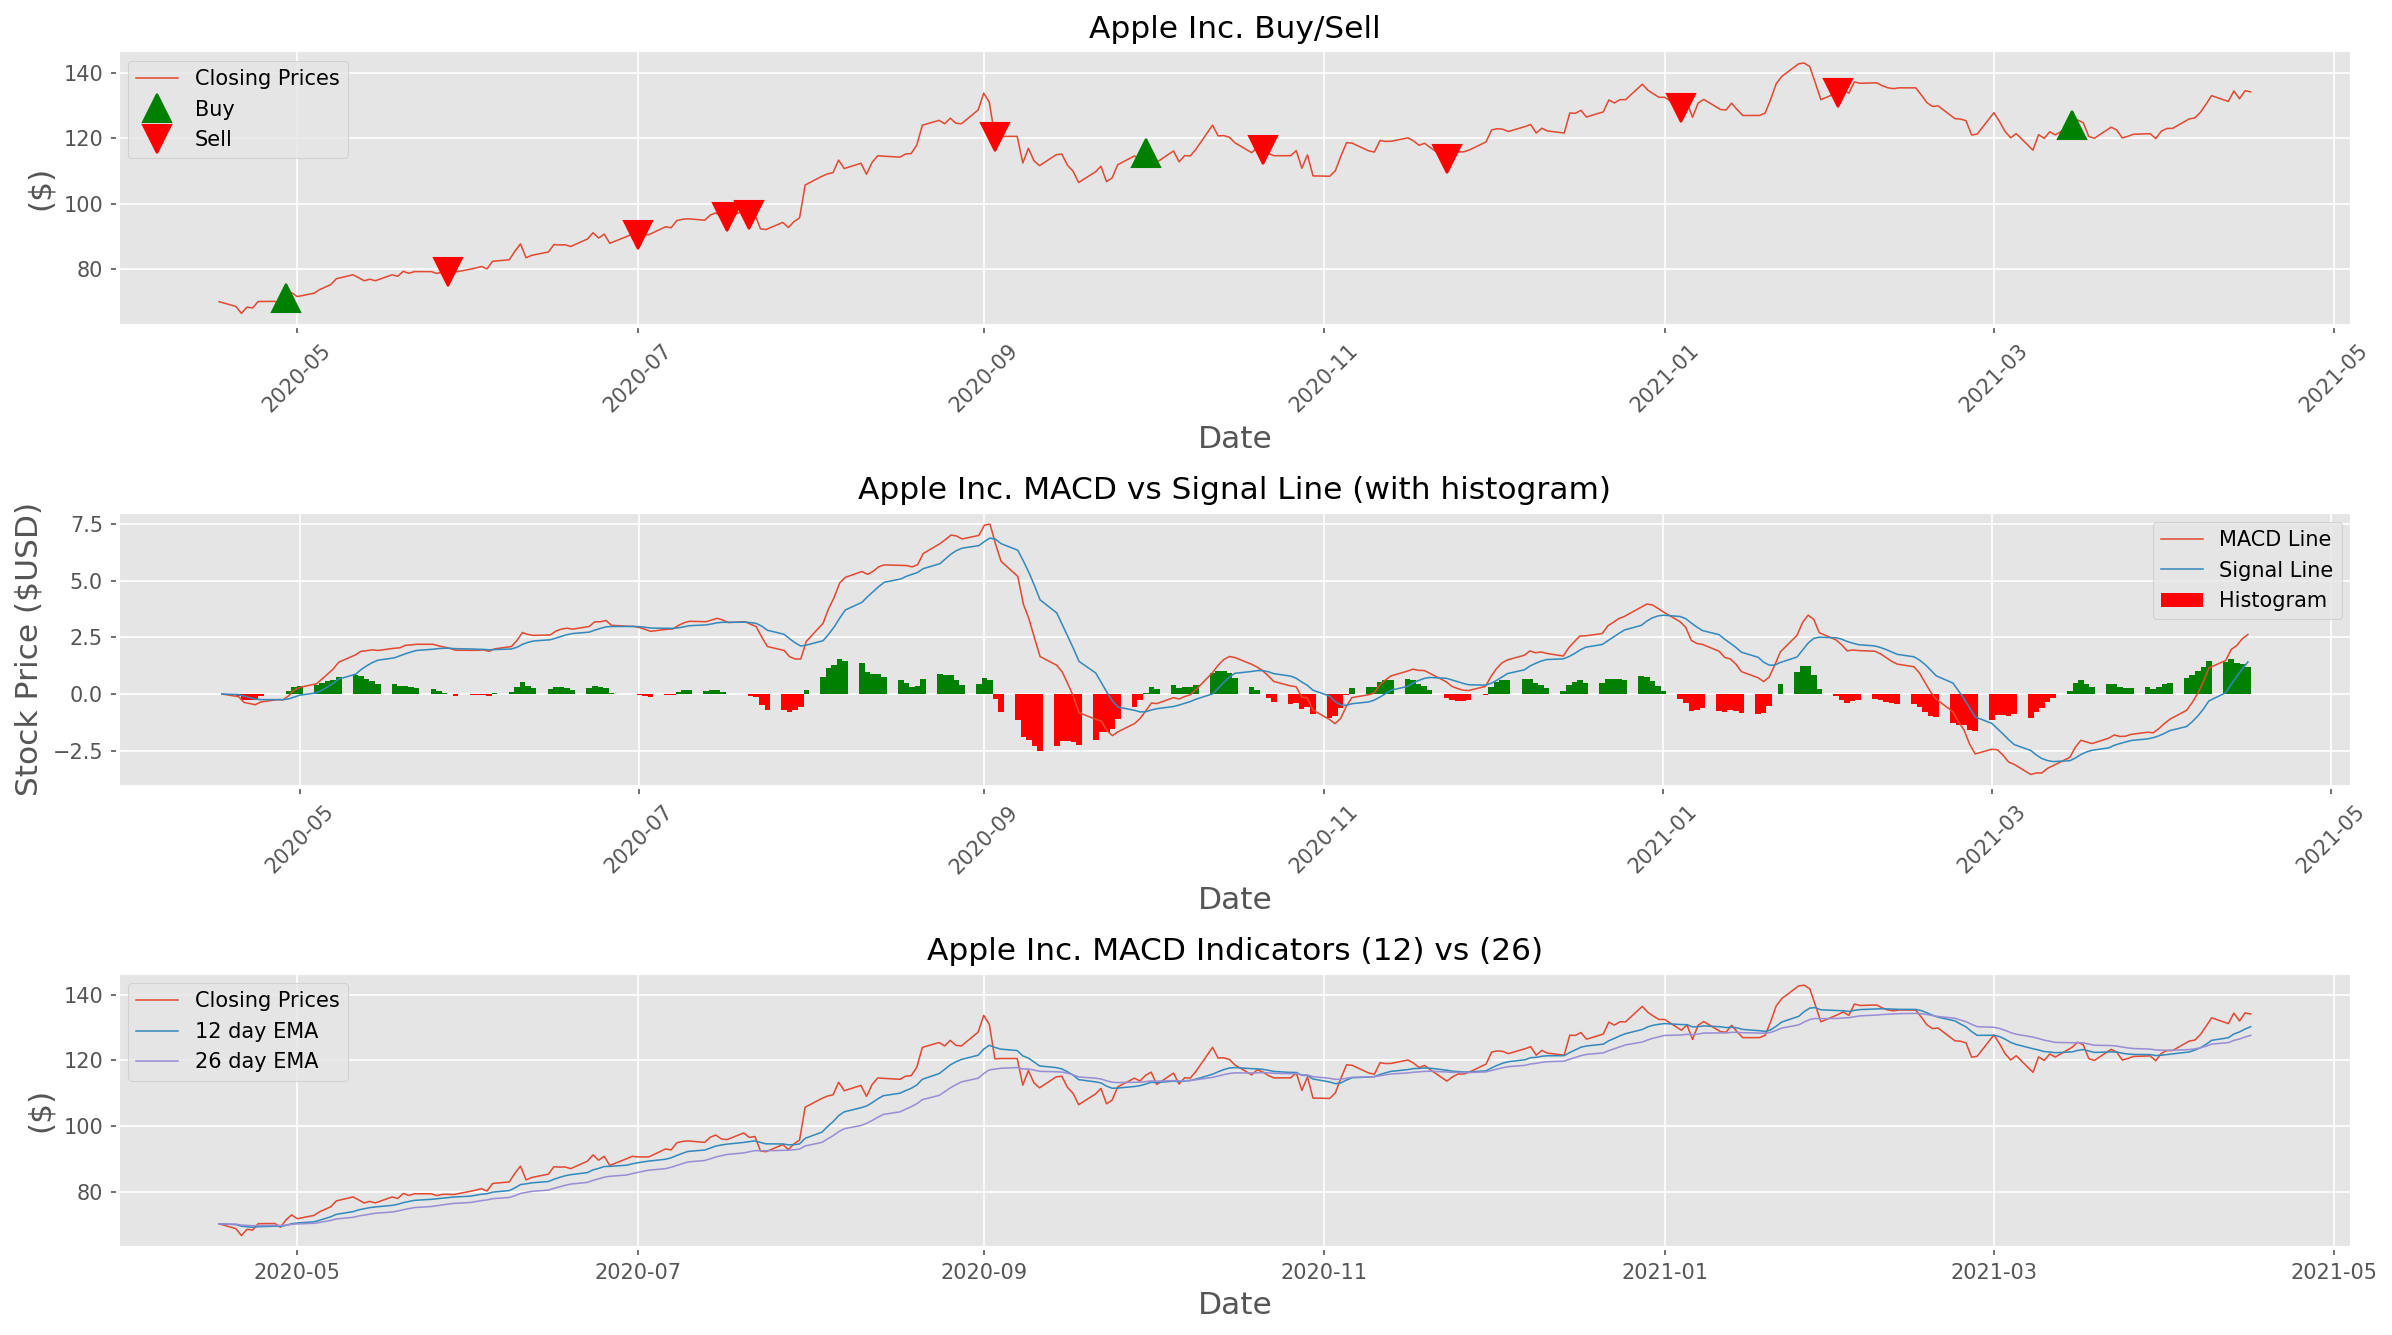

In [5]:
# Executing class and variables
MACD_indicator = MovingAverage(closing_prices)
MACD_line, signal_line, histogram = MACD_indicator.MACD()
COOLDOWN_PERIOD = 30
cooldown = 0



# Generating buy and sell signals
for i in range(1, len(closing_prices)):
    cooldown -= 1
    if i == 1:
        if MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
            high = 'MACD'
        else:
            high = 'SIGNAL'
    elif MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
        if high == 'SIGNAL': # MACD crossed signal - bottom to top BUY
            if MACD_line['EMA'].iloc[i] < 0 and cooldown <= 0:
                buy.iloc[i] = closing_prices[i] # BUY
                cooldown = COOLDOWN_PERIOD 
            high = 'MACD'
    elif MACD_line['EMA'].iloc[i] < signal_line['EMA'].iloc[i]:
        if high == 'MACD': # MACD crossed signal - top to bottom SELL
            if MACD_line['EMA'].iloc[i] > 0:
                sell.iloc[i] = closing_prices[i] # SELL
            high = 'SIGNAL'



# Plotting results 
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams["lines.linewidth"] = 0.75

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
plt.grid(True)

ax1.xaxis.set_tick_params(rotation=45)

ax1.plot(closing_prices, label = 'Closing Prices')
ax1.plot(buy, 'g^', markersize=13, label = 'Buy')
ax1.plot(sell, 'rv', markersize=13, label = 'Sell')
ax1.legend(loc='best')
ax1.title.set_text(f'{company} Buy/Sell')
ax1.set(xlabel='Date', ylabel='($)')

ax2.plot(MACD_line, label = 'MACD Line')
ax2.plot(signal_line, label = 'Signal Line')
histogram_y = [histogram['EMA'].iloc[i] for i in range(0, len(histogram))]
ax2.bar(histogram.index, histogram_y, color=['g' if histogram_y[i] > 0 else 'r' for i in range(0,len(histogram_y))], width = 1, label = 'Histogram')
ax2.legend(loc='best')
ax2.title.set_text(f'{company} MACD vs Signal Line (with histogram)')
ax2.xaxis.set_tick_params(rotation=45)
ax2.set(xlabel='Date', ylabel='Stock Price ($USD)')

ax3.plot(closing_prices, label = 'Closing Prices')
ax3.plot(MACD_indicator.EMA(12), label = '12 day EMA') # uncomment if you wish to plot the 12 day EMA 
ax3.plot(MACD_indicator.EMA(26), label = '26 day EMA') # uncomment if you wish to plot the 26 day EMA
ax3.legend(loc='best')
ax3.title.set_text(f'{company} MACD Indicators (12) vs (26)')
ax3.set(xlabel='Date', ylabel='($)')

plt.tight_layout()
plt.show()

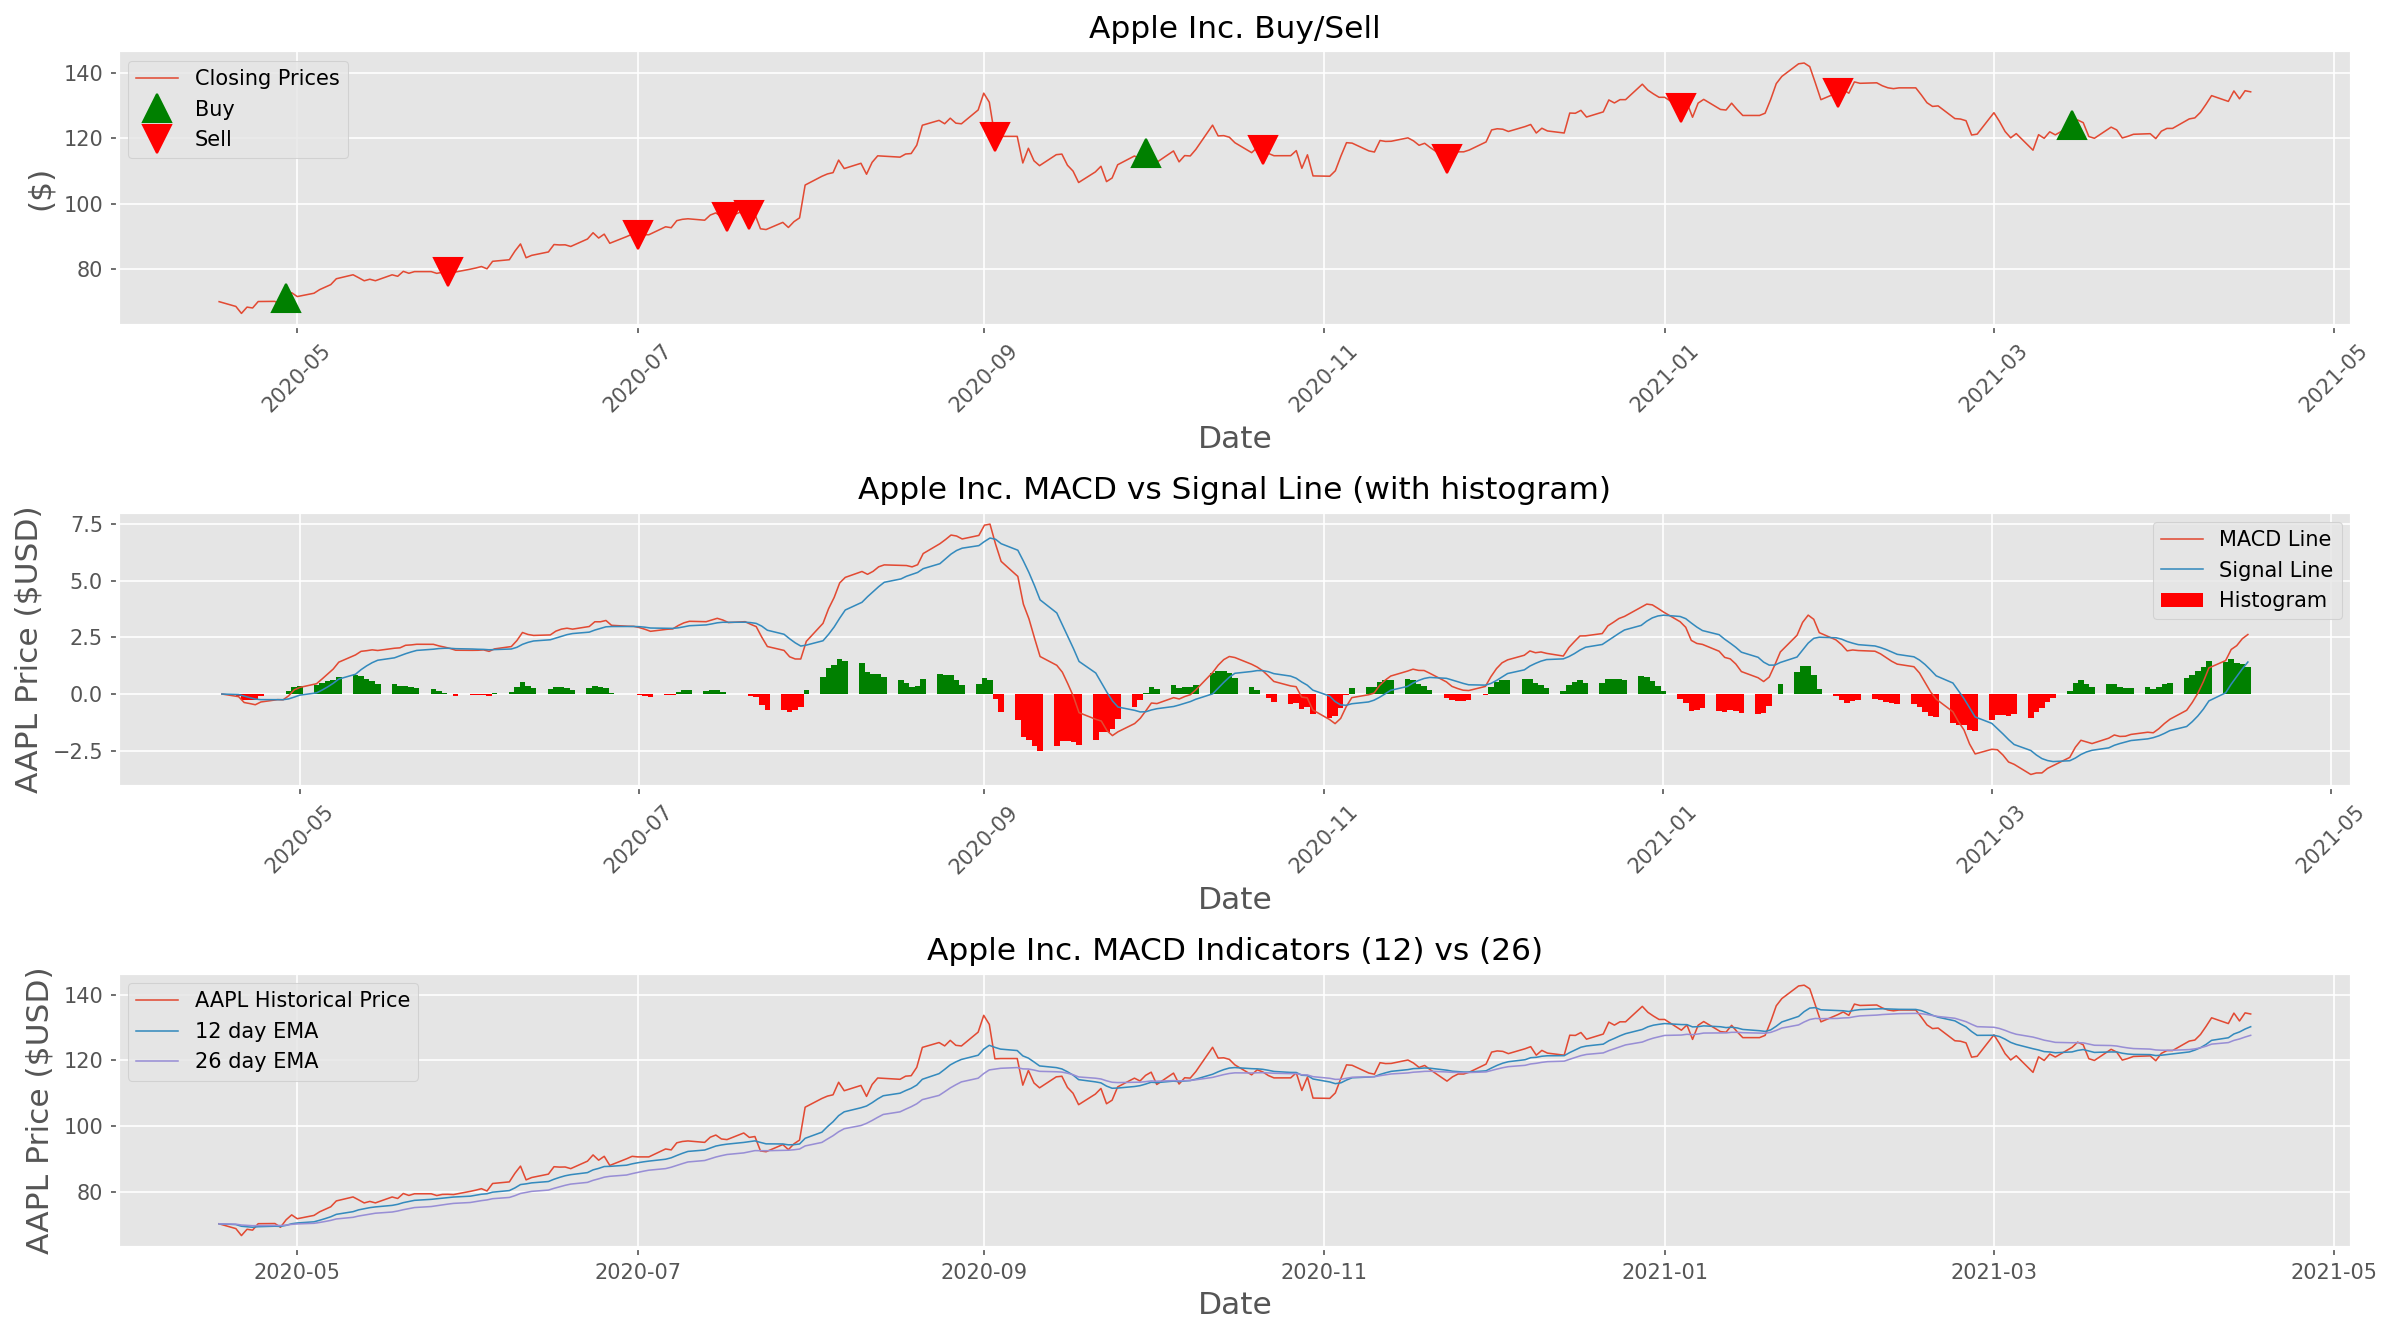

In [6]:
# Initial variables
INITIAL_INVESTMENT = 5000
net_portfolio = INITIAL_INVESTMENT

MAX_STOCK_PURCHASE = 1000 # maximum spent on each buy signal
BROKERAGE_FEE = 9.50 # Selfwealth brokerage fee

PROFIT_THRESHOLD = 1.2
COOLDOWN_PERIOD = 30 # number of elapsed days before another buy can be executed



# Plotting results 
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams["lines.linewidth"] = 0.75

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
plt.grid(True)

ax1.xaxis.set_tick_params(rotation=45)

ax1.plot(closing_prices, label = 'Closing Prices')
ax1.plot(buy, 'g^', markersize=13, label = 'Buy')
ax1.plot(sell, 'rv', markersize=13, label = 'Sell')
ax1.legend(loc='best')
ax1.title.set_text(f'{company} Buy/Sell')
ax1.set(xlabel='Date', ylabel='($)')

ax2.plot(MACD_line, label = 'MACD Line')
ax2.plot(signal_line, label = 'Signal Line')
histogram_y = [histogram['EMA'].iloc[i] for i in range(0, len(histogram))]
ax2.bar(histogram.index, histogram_y, color=['g' if histogram_y[i] > 0 else 'r' for i in range(0,len(histogram_y))], width = 1, label = 'Histogram')
ax2.legend(loc='best')
ax2.title.set_text(f'{company} MACD vs Signal Line (with histogram)')
ax2.xaxis.set_tick_params(rotation=45)
ax2.set(xlabel='Date', ylabel=f'{ticker_stock} Price ($USD)')

ax3.plot(closing_prices, label =f'{ticker_stock} Historical Price')
ax3.plot(MACD_indicator.EMA(12), label = '12 day EMA') # uncomment if you wish to plot the 12 day EMA 
ax3.plot(MACD_indicator.EMA(26), label = '26 day EMA') # uncomment if you wish to plot the 26 day EMA
ax3.legend(loc='best')
ax3.title.set_text(f'{company} MACD Indicators (12) vs (26)')
ax3.set(xlabel='Date', ylabel=f'{ticker_stock} Price ($USD)')

plt.tight_layout()
plt.show()

In [76]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
spy_ticker = yf.Ticker('SPY')
spy = yf.download('SPY')

[*********************100%***********************]  1 of 1 completed


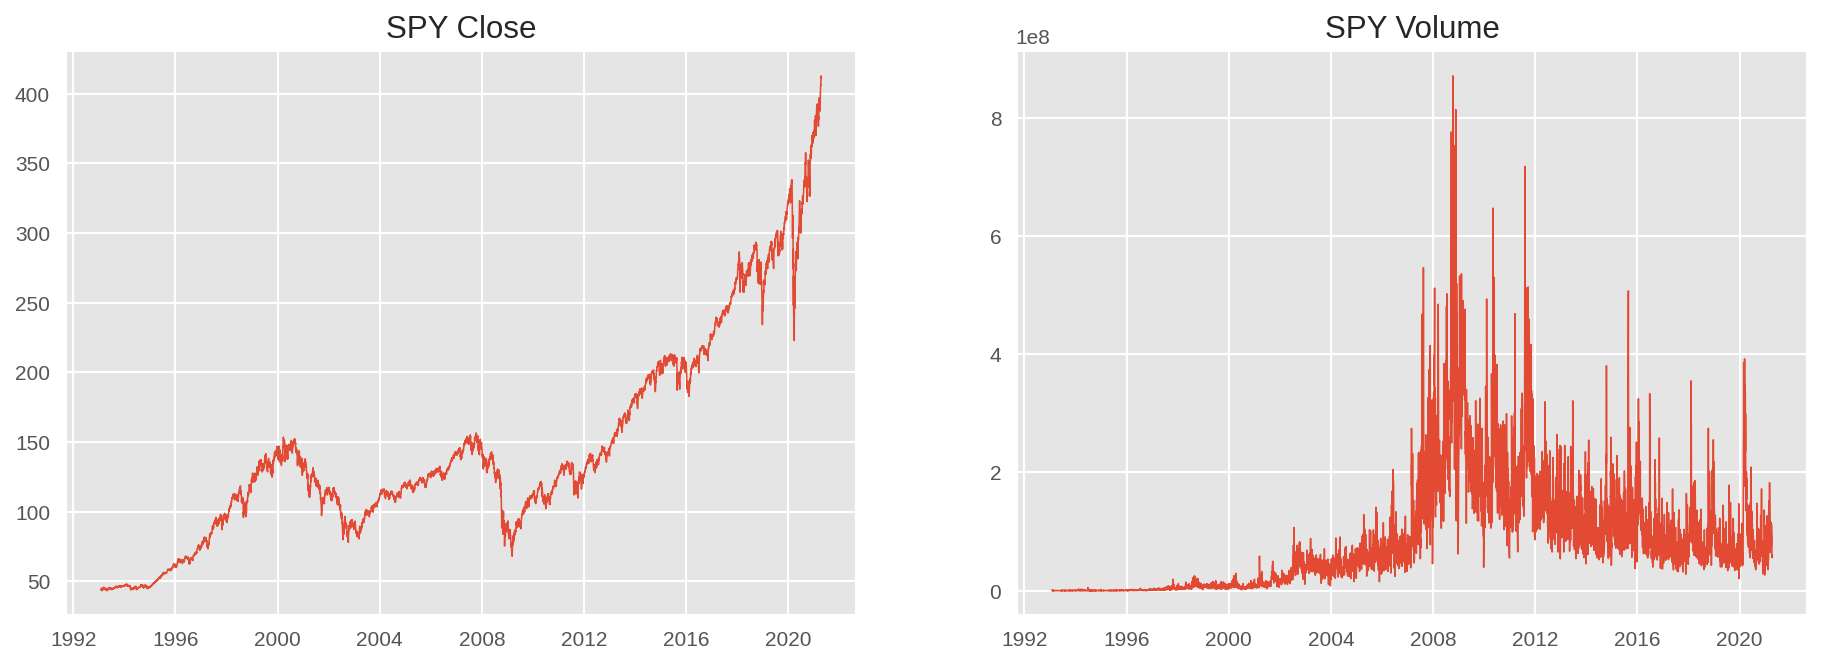

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15,5))
ax[0].set_title('SPY Close', fontsize=15)
ax[0].plot(spy['Close'])
ax[1].set_title('SPY Volume', fontsize=15)
ax[1].plot(spy['Volume'])

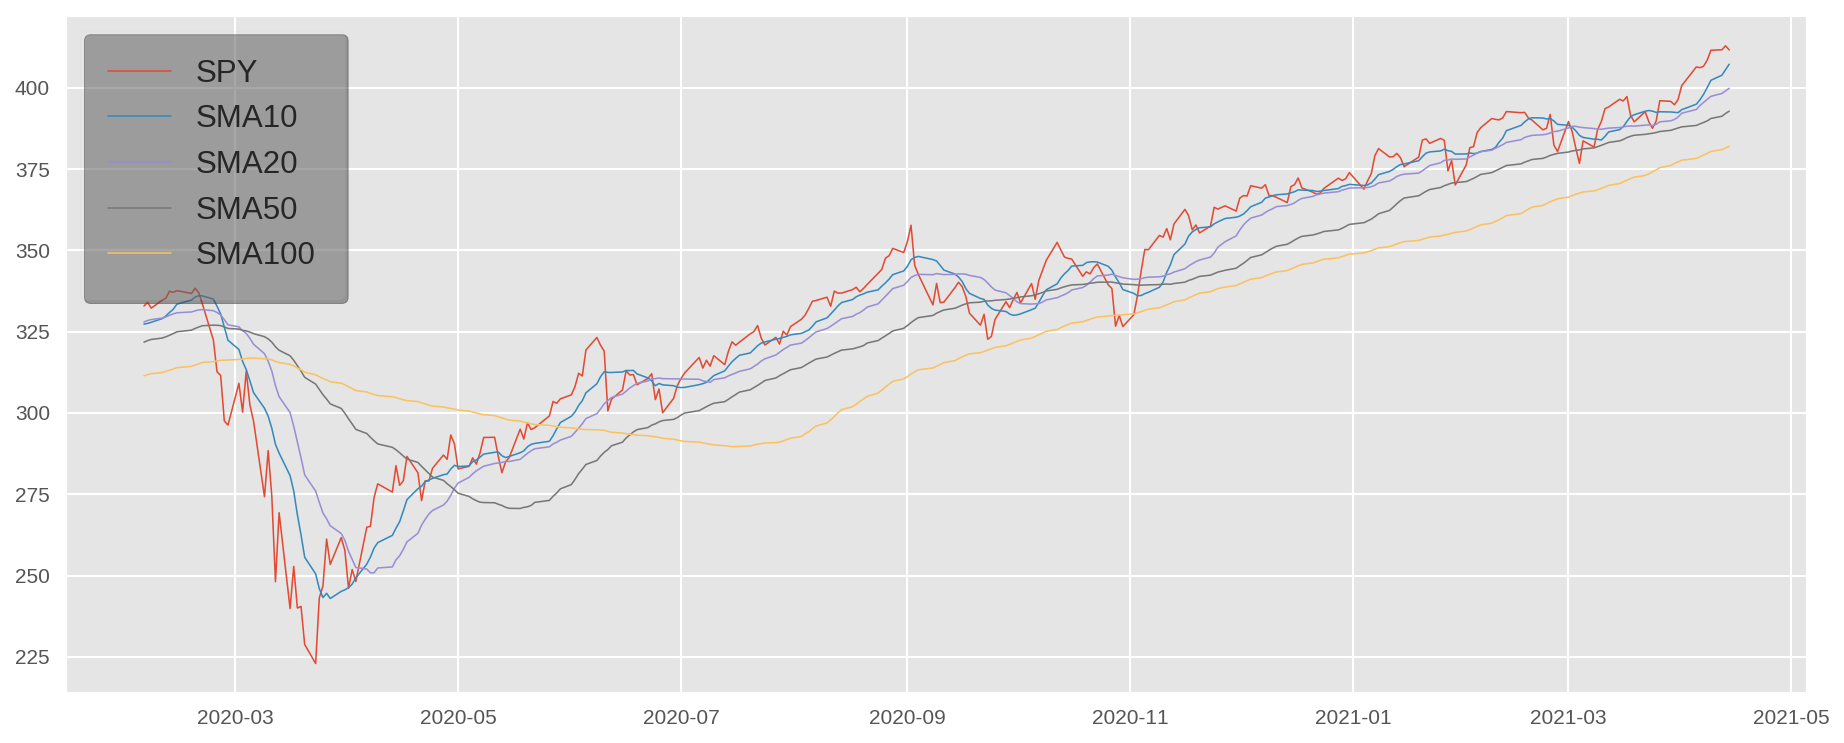

In [80]:
SMA10 = spy['Close'].rolling(window = 10).mean()
SMA20 = spy['Close'].rolling(window = 20).mean()
SMA50 = spy['Close'].rolling(window = 50).mean()
SMA100 = spy['Close'].rolling(window = 100).mean()


# taking last 300 trading days
plt.figure(figsize=(15, 6))
plt.plot(spy['Close'][-300:], label='SPY')
plt.plot(SMA10[-300:], label='SMA10')
plt.plot(SMA20[-300:], label='SMA20')
plt.plot(SMA50[-300:], label='SMA50')
plt.plot(SMA100[-300:], label='SMA100')
plt.legend(loc='upper left', fontsize=15)

In [81]:
def get_points_above(sma_low, sma_high):
    points_above = {}
    for pair in zip(sma_low, sma_high):
        if pair[0] >= pair[1]:
            date = sma_low[sma_low == pair[0]].index[0]
            points_above[date] = pair[0]
            
    points_above = pd.Series(points_above, name='Price_Points')
    points_above.index.name = 'Date'
            
    return points_above
points_above_SMA50 = get_points_above(SMA20, SMA50)

In [82]:
SMA20 = SMA20.reset_index()
SMA50 = SMA50.reset_index()

In [85]:
crossovers = pd.DataFrame()
crossovers['Dates'] = SMA20['Date']
crossovers['Price'] = [i for i in spy['Close']]
crossovers['SMA20'] = SMA20['Close']
crossovers['SMA50'] = SMA50['Close']
crossovers['position'] = crossovers['SMA20'] >= crossovers['SMA50']
crossovers['pre-position'] = crossovers['position'].shift(1)
crossovers['Crossover'] = np.where(crossovers['position'] == crossovers['pre-position'], False, True)
crossovers['Crossover'][0] = False
# print(crossovers)
crossovers

,Dates,Price,SMA20,SMA50,position,pre-position,Crossover
0,1993-01-29,43.937500,NaN,NaN,False,NaN,False
1,1993-02-01,44.250000,NaN,NaN,False,False,False
2,1993-02-02,44.343750,NaN,NaN,False,False,False
3,1993-02-03,44.812500,NaN,NaN,False,False,False
4,1993-02-04,45.000000,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...
7098,2021-04-08,408.519989,396.423000,389.781200,True,True,False
7099,2021-04-09,411.489990,397.320999,390.522800,True,True,False
7100,2021-04-12,411.640015,398.200000,391.203000,True,True,False
7101,2021-04-13,412.859985,399.022499,392.058799,True,True,False


In [86]:
crossovers = crossovers.loc[crossovers['Crossover'] == True]
crossovers = crossovers.reset_index()
crossovers = crossovers.drop(['position', 'pre-position', 'Crossover', 'index'], axis=1)
crossovers['Signal'] = np.nan
crossovers['Binary_Signal'] = 0.0
for i in range(len(crossovers['SMA20'])):
    if crossovers['SMA20'][i] > crossovers['SMA50'][i]:
        crossovers['Binary_Signal'][i] = 1.0
        crossovers['Signal'][i] = 'Buy'
    else:
        crossovers['Signal'][i] = 'Sell'
# print(crossovers)
crossovers

,Dates,Price,SMA20,SMA50,Signal,Binary_Signal
0,1993-04-12,44.906250,44.862500,44.687500,Buy,1.0
1,1993-04-23,43.750000,44.642187,44.680000,Sell,0.0
2,1993-05-27,45.437500,44.603125,44.599375,Buy,1.0
3,1993-07-13,44.906250,44.796875,44.818125,Sell,0.0
4,1993-08-11,45.187500,44.917187,44.908125,Buy,1.0
...,...,...,...,...,...,...
150,2019-09-18,301.100006,295.012003,294.935999,Buy,1.0
151,2020-03-03,300.239990,325.264503,325.374002,Sell,0.0
152,2020-04-30,290.480011,276.872002,276.395601,Buy,1.0
153,2020-09-30,334.890015,335.207004,335.222801,Sell,0.0


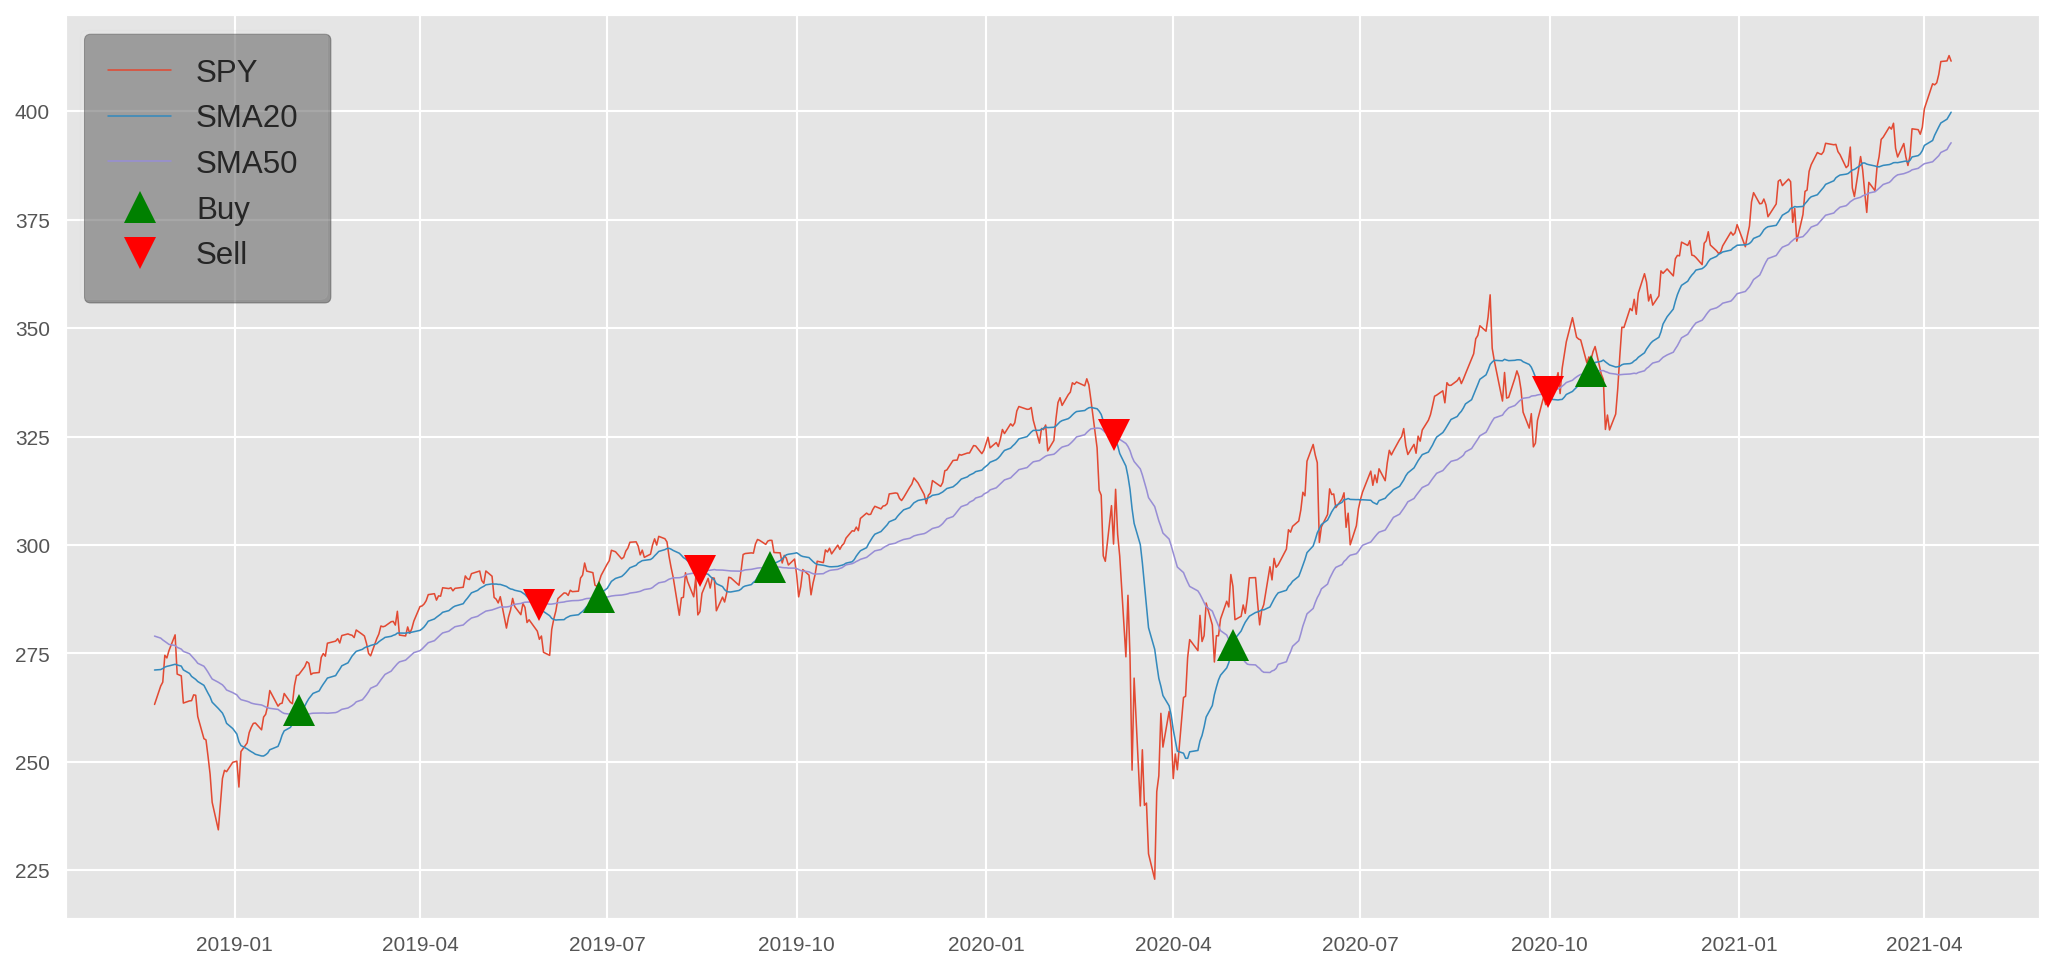

In [87]:
# taking last 600 trading days
SMA20 = spy['Close'].rolling(window=20).mean()
SMA50 = spy['Close'].rolling(window=50).mean()
plt.figure(figsize=(17, 8))
plt.plot(spy['Close'][-600:], label='SPY')
plt.plot(SMA20[-600:], label='SMA20')
plt.plot(SMA50[-600:], label='SMA50')
plt.plot(crossovers.loc[crossovers.Signal == 'Buy']['Dates'][-5:], 
         crossovers['SMA20'][crossovers.Signal == 'Buy'][-5:],
        '^', markersize=15, color='g', label='Buy')
plt.plot(crossovers.loc[crossovers.Signal == 'Sell']['Dates'][-4:], 
         crossovers['SMA20'][crossovers.Signal == 'Sell'][-4:],
        'v', markersize=15, color='r', label='Sell')
plt.legend(loc='upper left', fontsize=15)